In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS
import clustering as clstr
import bout.assembly as bt
import bout.clustering as clstr
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline

from cli import get_file_paths

In [4]:
site_key = 'Carp'
freq_key = 'HF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Carp Pond


In [5]:
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)

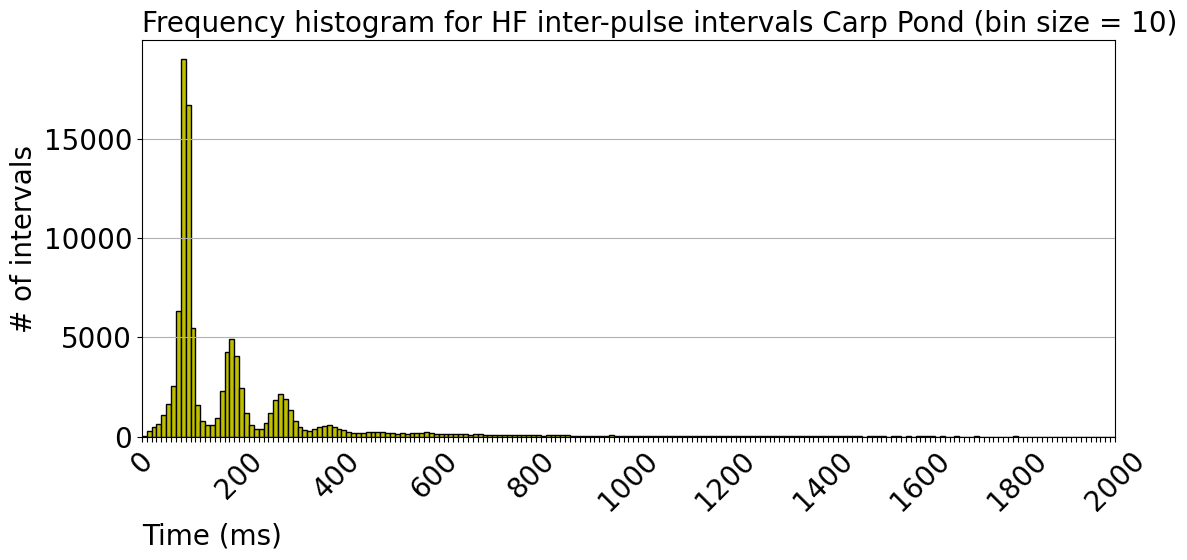

In [6]:
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df.copy(), fig_details)

In [8]:
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 1193583478 missassigned points
Slater method has 1969127 missassigned points
Sibly method has 2853760 missassigned points
Optim BCI has less misassignments than BCI? False


In [9]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.0010389163825586332, intercept=10.422306270123315, rvalue=-0.8384852600896073, pvalue=2.2827582508999162e-54, stderr=4.7862434095433106e-05, intercept_stderr=0.05533581876787737),
  'indices': array([ True,  True,  True, ..., False, False, False]),
  'lambda': 0.0010389163825586332,
  'num_intervals_slater': 32342196.183165878},
 {'metrics': LinregressResult(slope=-3.1159576797701164e-07, intercept=5.918666840439488, rvalue=-0.9254751852343245, pvalue=0.0, stderr=1.0326223130834791e-10, intercept_stderr=0.0009148455577760446),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 3.1159576797701164e-07,
  'num_intervals_slater': 1193583477.8929164})

In [10]:
nlin_results

{'solution': array([1.25565223e+08, 8.70189944e-04, 1.19358348e+09, 3.11595768e-07]),
 'fast_num_intervals': 125565223.16997232,
 'fast_lambda': 0.0008701899444075448,
 'slow_num_intervals': 1193583478.3475742,
 'slow_lambda': 3.115957680486141e-07,
 'bci': 6532.947983665437}

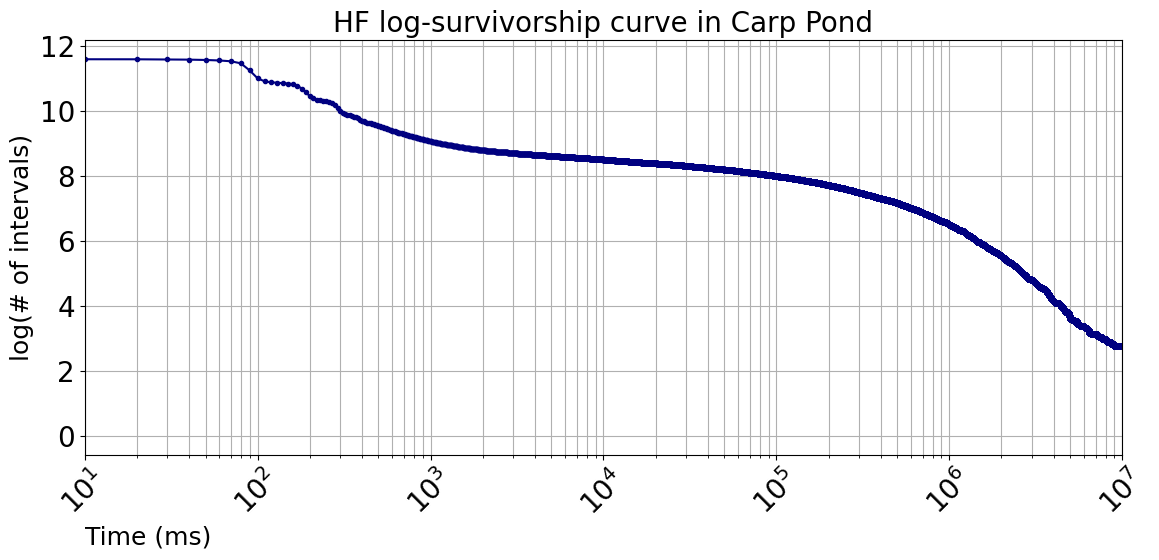

In [11]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)

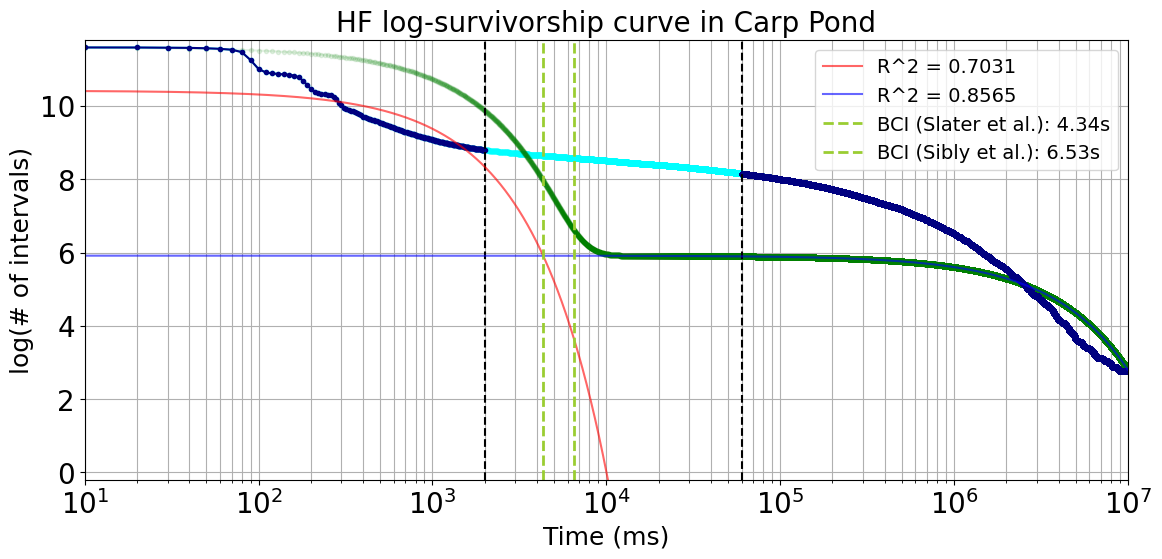

In [12]:
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Fagen&Young method has 1526194780 missassigned points
Slater method has 343871 missassigned points
Sibly method has 321745 missassigned points
Optim BCI has less misassignments than BCI? True
22126 more points assigned correctly


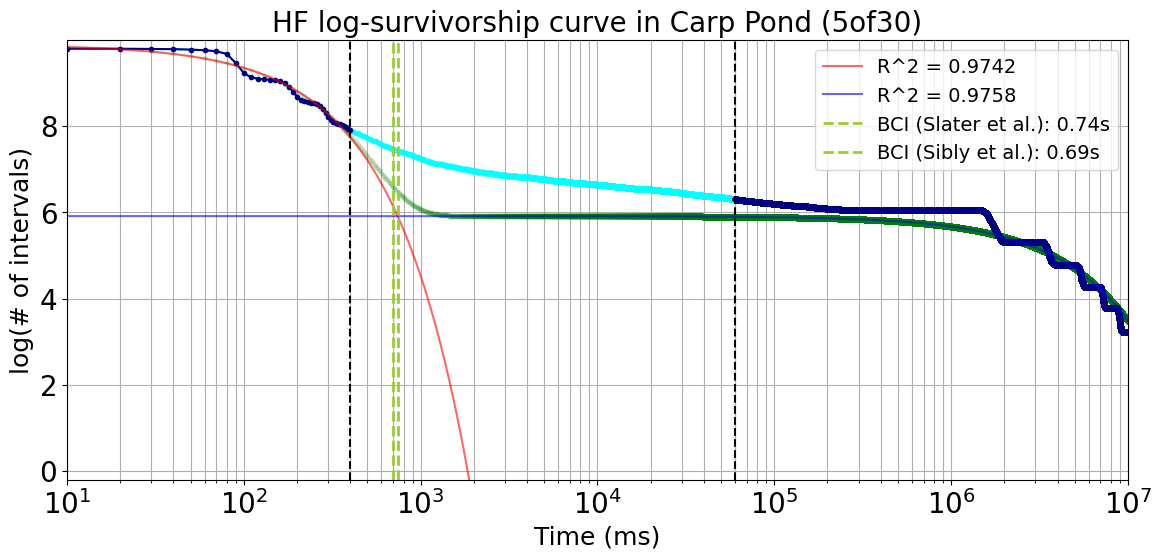

In [14]:
data_params = dict()
data_params['type_tag'] = freq_key
data_params['site_tag'] = site_key
data_params['cur_dc_tag'] = '5of30'
data_params['bin_size'] = '30'
data_params['detector_tag'] = 'bd2'
data_params['use_thresholds'] = False
data_params['use_kmeans'] = True
fig_details['site_name'] = SITE_NAMES[site_key] + ' ' + f"({data_params['cur_dc_tag']})"

file_paths = get_file_paths(data_params)

location_df = ss.prepare_summary_for_plotting_with_duty_cycle_and_bins(file_paths, data_params['cur_dc_tag'], data_params['bin_size'])
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Fagen&Young method has 1358936595 missassigned points
Slater method has 265732 missassigned points
Sibly method has 253444 missassigned points
Optim BCI has less misassignments than BCI? True
12288 more points assigned correctly


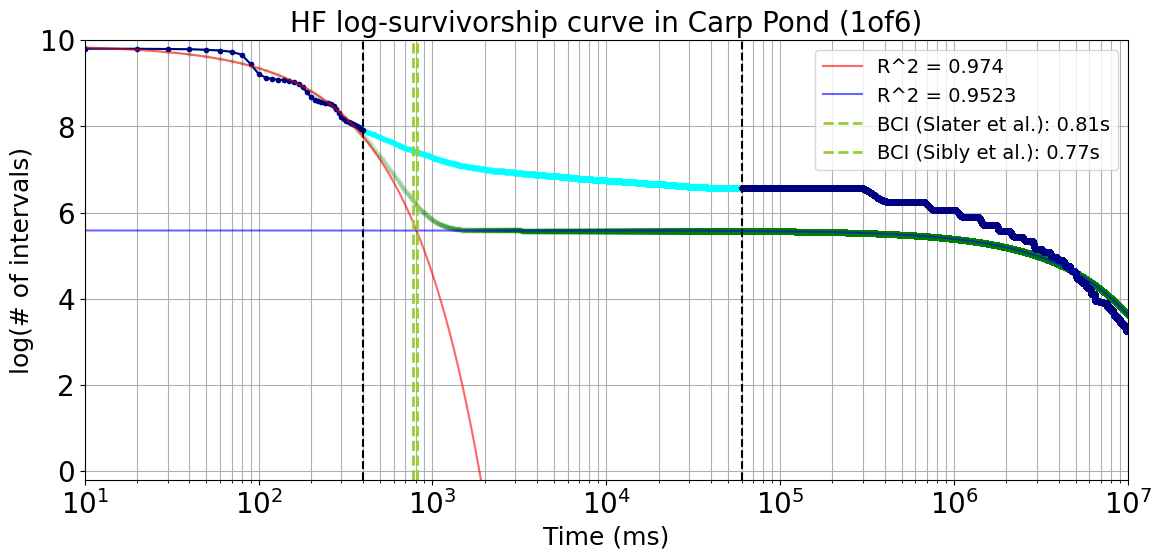

In [15]:
data_params = dict()
data_params['type_tag'] = freq_key
data_params['site_tag'] = site_key
data_params['cur_dc_tag'] = '1of6'
data_params['bin_size'] = '30'
data_params['detector_tag'] = 'bd2'
data_params['use_thresholds'] = False
data_params['use_kmeans'] = True
fig_details['site_name'] = SITE_NAMES[site_key] + ' ' + f"({data_params['cur_dc_tag']})"

file_paths = get_file_paths(data_params)

location_df = ss.prepare_summary_for_plotting_with_duty_cycle_and_bins(file_paths, data_params['cur_dc_tag'], data_params['bin_size'])
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)